## NeuroAlign - Inference

This notebook can be used to predict alignments from fasta files of unaligned sequences using a pretrained NeuroAlign model.

NeuroAlign is a deep learning based end-to-end model that is able to construct multiple sequence alignments / representations of
protein families by learning from datasets of reference alignments. Our model maps raw sequences
\- for instance over the standard aminoacid alphabet but not limited to that \- to a soft alignment represented by a probablity distribution for each residuum over a (dynamically sized) sequence of alignment columns (the consensus). NeuroAlign can also output representation vectors for the alignment columns which encode the respective distribution of aminoacids and which can be useful for higher level learning tasks.

The weight files provided with this notebook are trained on Pfam. We used all 18259 protein families available at the time of our access, but only their respective seed alignments.

### Requirements

This notebook requires tensorflow (2.1 or higher) and matplotlib. Other than that, it is self-contained. 

Model weight files are provided with github under ./models.

If a GPU is present, the notebook will automatically attempt to use it. The base model (./models/base) requires at least 7GBs of GPU memory. 
To force a CPU run, the following flag must be set to True. 

In [ ]:
IGNORE_GPU = False 

## Setting up the model

We provide configurated and pretrained "out of the box" models. All what has to be done is to load a model using its identifier.

In [2]:
import Model as model

neuroalign, neuroalign_config = model.make_neuro_align_model("base")

Successfully loaded weights: base model


## Loading a fasta file
NeuroAlign operates on raw sequences of aminoacids in fasta file format. Sequences can come in any number and order. The model is inherently invariant to permuntations of the sequences. For large numbers of sequences, GPU memory might overflow (TODO suggest numbers). Disabling GPU and running on CPU can fix this.

We use a custom Fasta object to parse a file. Afterwards, we convert to a numeric "one-hot" format which can be passed to the NeuroAlign model.

In [3]:
import sys
import Data as data

#######################################################################################
################ you may modify these variables to test NeuroAlign ####################
#######################################################################################

file = "./data/BB11001.fasta"

# set this to True, if the fasta file is already aligned 
# i.e. it contains gap symbols and all sequences have the same length
# if True, the gap symbols will be automatically stripped away before inference and will
# only be used for evaluating the model output
# if False, the model will just compute its output and skip all evaluation
has_gaps = True 

#######################################################################################
#######################################################################################
#######################################################################################

fasta_file = data.Fasta(file, gaps = has_gaps, contains_lower_case = True)

if not fasta_file.valid:
    sys.exit("Invalid fasta file.")

selected_sequences = list(range(len(fasta_file.raw_seq))) #all and in order
if has_gaps:
    input_dict, target_dict = data.get_input_target_data(fasta_file, selected_sequences, neuroalign_config)
else:
    seq = fasta_file.one_hot_sequences(selected_sequences)
    input_dict = {"sequences" : seq}
    
print("Successfully loaded file:", file)

Successfully loaded file: ./data/BB11001.fasta


NeuroAlign is an autoregressive model that predicts a consensus sequence of columns one at a time. Its decision for the aminoacid distribution of a column is based on all sequences and all previously predicted columns. Inference internally starts with a consensus consisting only of a special "column start" marker. It is then rolled out autoregressively in order to generate columns until a "column end" marker is predicted or a maximal length (default 1000) is reached.

We provide a method for generating the columns this way.

In [4]:
# generates a 2D tensor "column_distributions" with shape [num_columns, alphabet_size]
# and a 3D tensor "attention_weights" with shape [num_seq, len_seq, num_cols]
column_distributions, attention_weights = model.gen_columns(input_dict, neuroalign, neuroalign_config)

print("Prediction run on file", fasta_file.filename, "with", len(fasta_file.raw_seq), 
      "sequences of average length", sum(fasta_file.seq_lens) / len(fasta_file.raw_seq), ".")
print("Predicted a soft alignment with", column_distributions.shape[0], "columns.")
if has_gaps:
    print("The reference has", fasta_file.alignment_len, "columns.")

Prediction run on file ./data/BB11001.fasta with 4 sequences of average length 86.25 .
Predicted a soft alignment with 98 columns.
The reference has 96 columns.


## Evaluation

So far, a soft alignment was predicted and we seek to evaluate it. NeuroAlign uses an attention mechanism that measures the degree of importance of a residuum to a particular column. A good way to visualize the prediction is to plot the attention weights (which can be interpreted as a probability distribution per residuum over all columns). This way, ee can make a visual comparison of the reference alignment with the predicted attention scores. 

Furthermore, we need a way to evaluate the models performance in terms of numeric metrics. To that end, we compute precision and recall for all binary variables "residuum X and residuum Y are aligned".

alignment precision:  0.40278918
alignment recall:  0.36834207
alignment precision (teacher forced):  0.9816794
alignment recall (teacher forced):  0.9647412


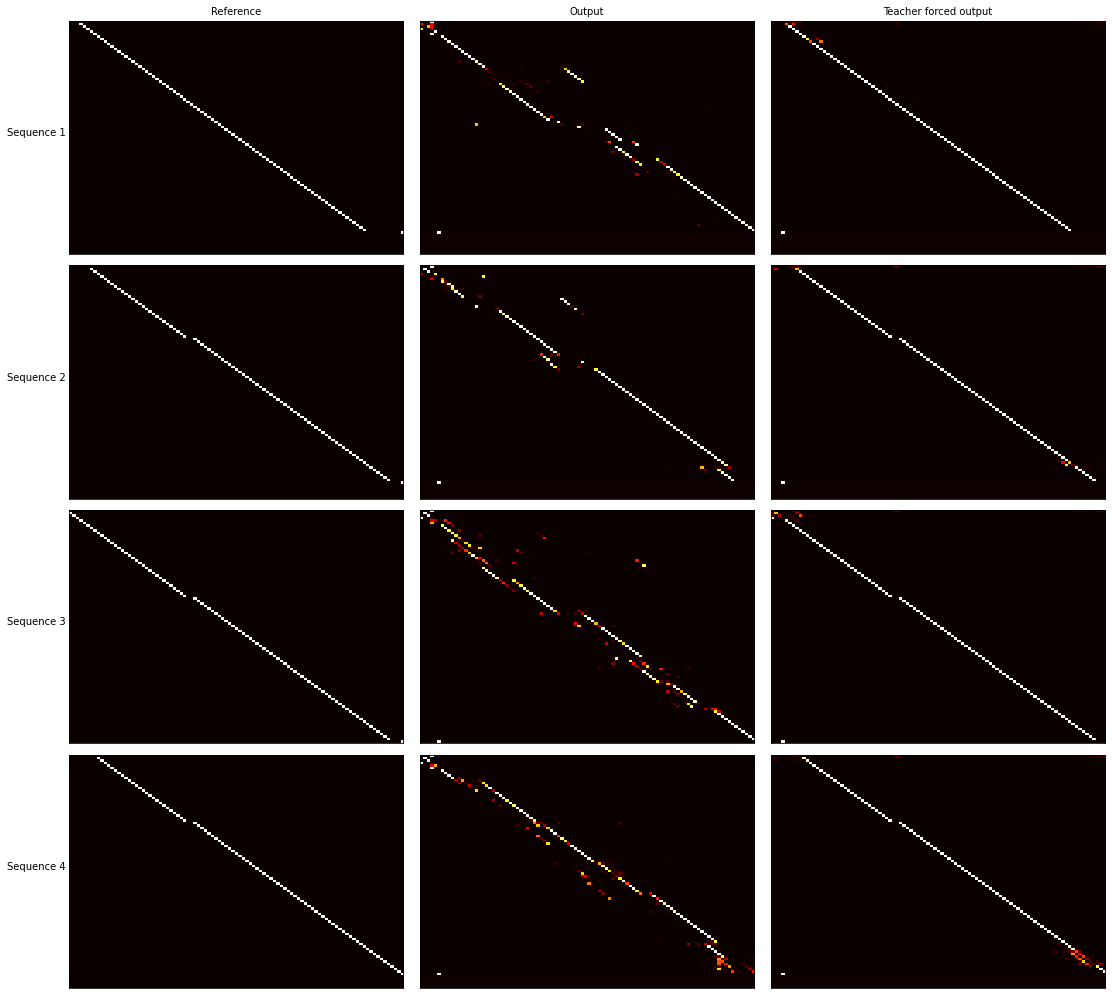

In [5]:
import Evaluation as evl

#for comparison compute the output with teacher forcing enabled
#i.e. when predicting column i the model knowns how reference columns 1...i-1 look like
_, teacher_forced_attention_weights = neuroalign(input_dict)

evl.plot_memberships(target_dict["out_attention"], [attention_weights,teacher_forced_attention_weights], ["Output", "Teacher forced output"])

#we ignore the first sequence symbol which is internally used as a "gap dummy"
#and the first columns, which is the "column start" marker
p = evl.precision(target_dict["out_attention"], attention_weights).numpy()
r = evl.recall(target_dict["out_attention"], attention_weights).numpy()

print("alignment precision: ", p)
print("alignment recall: ", r)


p = evl.precision(target_dict["out_attention"], teacher_forced_attention_weights).numpy()
r = evl.recall(target_dict["out_attention"], teacher_forced_attention_weights).numpy()

print("alignment precision (teacher forced): ", p)
print("alignment recall (teacher forced): ", r)

We have ways to ensure the quality of the predicted soft alignment. However, we have no direct and simple way of constructing a complete alignment based on the attention matrix (that is, generating sequences with gap symbols and writing them to an output file).